# Emergency - 911 Calls

#### Import necessary libraries

In [1]:
# numpy & pandas
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
% matplotlib inline
import seaborn as sns

# date time modules
from datetime import datetime
import time
import calendar

# preprocessing & split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# scoring
from sklearn.metrics import r2_score

# models
from sklearn.linear_model import LinearRegression
import xgboost as xgb

#### Load Dataset

In [2]:
# Load the 911 dataset
data = pd.read_csv('911.csv')

print('911 dataset loaded successfully!')
print ('The dataset has {} datapoints with {} features each'.format(*data.shape))

911 dataset loaded successfully!
The dataset has 326425 datapoints with 9 features each


In [3]:
data.head(2)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,12/10/2015 17:10,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,12/10/2015 17:29,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1


In [4]:
# check the timestamp range in dataset
print ('Start Date in dataset : {}'.format(pd.to_datetime(data['timeStamp']).min()))
print ('End date in dataset : {}'.format(pd.to_datetime(data['timeStamp']).max()))

Start Date in dataset : 2015-12-10 14:39:00
End date in dataset : 2018-03-24 13:15:00


In [5]:
# check the number of records in each year
print ('Number of records in the year 2015 : {}'.format(data['timeStamp'][data['timeStamp'].str.contains('2015') == True].count()))
print ('Number of records in the year 2016 : {}'.format(data['timeStamp'][data['timeStamp'].str.contains('2016') == True].count()))
print ('Number of records in the year 2017 : {}'.format(data['timeStamp'][data['timeStamp'].str.contains('2017') == True].count()))
print ('Number of records in the year 2018 : {}'.format(data['timeStamp'][data['timeStamp'].str.contains('2018') == True].count()))

Number of records in the year 2015 : 7916
Number of records in the year 2016 : 142360
Number of records in the year 2017 : 139617
Number of records in the year 2018 : 36532


#### Outlier Removal

Finding the distinct values of township "twp" in next step, to confirm if every town belongs to Montgomery county.

In [6]:
# check for unique town names
print (data.twp.unique())

['NEW HANOVER' 'HATFIELD TOWNSHIP' 'NORRISTOWN' 'LOWER POTTSGROVE'
 'LANSDALE' 'HORSHAM' 'SKIPPACK' 'LOWER SALFORD' 'PLYMOUTH' 'MONTGOMERY'
 'UPPER MORELAND' 'CHELTENHAM' 'UPPER MERION' 'WHITEMARSH' 'UPPER GWYNEDD'
 'LOWER PROVIDENCE' 'UPPER DUBLIN' 'WHITPAIN' 'DELAWARE COUNTY'
 'FRANCONIA' 'WEST CONSHOHOCKEN' 'LOWER MERION' 'LIMERICK' 'TOWAMENCIN'
 'DOUGLASS' 'POTTSTOWN' 'BRIDGEPORT' 'AMBLER' 'CHESTER COUNTY'
 'UPPER HANOVER' 'SPRINGFIELD' 'ROCKLEDGE' 'ABINGTON' 'WEST NORRITON'
 'ROYERSFORD' 'UPPER SALFORD' 'LOWER MORELAND' 'CONSHOHOCKEN' 'PENNSBURG'
 'TELFORD' 'EAST NORRITON' 'UPPER FREDERICK' 'UPPER PROVIDENCE' 'SALFORD'
 'HATFIELD BORO' 'LEHIGH COUNTY' 'LOWER GWYNEDD' 'MARLBOROUGH'
 'BRYN ATHYN' 'HATBORO' 'WORCESTER' 'COLLEGEVILLE' 'SCHWENKSVILLE'
 'PERKIOMEN' 'SOUDERTON' 'UPPER POTTSGROVE' 'LOWER FREDERICK'
 'BUCKS COUNTY' 'RED HILL' 'WEST POTTSGROVE' 'EAST GREENVILLE'
 'BERKS COUNTY' 'NORTH WALES' 'JENKINTOWN' 'TRAPPE' nan 'NARBERTH'
 'GREEN LANE' 'PHILA COUNTY']


The 6 towns - 'PHILA COUNTY', 'LEHIGH COUNTY', 'DELAWARE COUNTY', 'CHESTER COUNTY', 'BUCKS COUNTY', 'BERKS COUNTY' does not belong to Montgomery county at all.

In [7]:
# number of records in each outlier town
data['twp'][data['twp'].isin(['PHILA COUNTY', 
                              'LEHIGH COUNTY', 
                              'DELAWARE COUNTY', 
                              'CHESTER COUNTY', 
                              'BUCKS COUNTY', 
                              'BERKS COUNTY'])].value_counts()

CHESTER COUNTY     3543
BUCKS COUNTY       1173
BERKS COUNTY        880
DELAWARE COUNTY     871
PHILA COUNTY        124
LEHIGH COUNTY        73
Name: twp, dtype: int64

In [8]:
# remove outliers
county_outliers = ['PHILA COUNTY', 'LEHIGH COUNTY', 'DELAWARE COUNTY', 'CHESTER COUNTY', 'BUCKS COUNTY', 'BERKS COUNTY']
data = data[~data['twp'].isin(county_outliers)].reset_index(drop=True)

#### Analyzing latitude, longitude coordinates

In [9]:
# Maximum and minimum value of latitude and longitude in the dataset
start_lat = min(data['lat'])
end_lat = max(data['lat'])
start_lng = min(data['lng'])
end_lng = max(data['lng'])
print ('Minimum & Maximum latitude value: {}, {}'.format(start_lat, end_lat))
print ('Minimum and Maximum longitude value: {}, {}'.format(start_lng, end_lng))

Minimum & Maximum latitude value: 30.333596000000004, 41.1671565
Minimum and Maximum longitude value: -95.5955947, -74.280113


#### Remove error records

From Google maps, it is found that, Montgomery, PA, lies in the below latitude - longitude range:

    latitude range = (39.97, 40.46)
    longitude range = (-75.71, -74.90)
    
So, any point lying out of this range (eventhough the town name belongs to the county, because it is contradictory) is an error record. These error records will be found and removed in the following steps.

In [10]:
# Finding latitude - longitude outliers due to human error
montco_min_lat = 39.97
montco_max_lat = 40.46
montco_min_lng = -75.71
montco_max_lng = -74.90

relax_value = 0 #relax_value = 2
lat_lng_outliers = (data.loc[(data['lat'] < (montco_min_lat - relax_value)) | 
                    (data['lat'] > (montco_max_lat + relax_value)) | 
                    (data['lng'] < (montco_min_lng - relax_value)) | 
                    (data['lng'] > (montco_max_lng + relax_value))])

print (len(lat_lng_outliers))

44


The 44 data points in the above output are latitude - logitude outliers due to human error, which will be removed in the next step.

In [11]:
data = data[~(data['lat'].isin(lat_lng_outliers['lat']) & data['lng'].isin(lat_lng_outliers['lng']))].reset_index(drop=True)

Let us see the size of the dataset after removing other county data points and latitude - longitude error.

In [12]:
print ('The size of the dataset after removing error datapoints is : {}'.format(len(data)))

The size of the dataset after removing error datapoints is : 319717


#### Split into regions

The latitude, longitude values could be used to form a grid (4x4). Then the corresponding latitude grid number and longitude grid number will be noted down for each data point. This will be used to find the region (out of 16 regions because this is a 4x4 grid) which the data point belongs to.

In [13]:
# "lat" and "lng" column values are assigned to a grid of size 4 x 4 (lat x lng or horizontal x vertical) 
# The new columns are "lat_grid_no" and "lng_grid_no" which can take values from 0 to 3 both.

start_lat = min(data['lat'])
end_lat = max(data['lat']) + 0.1 # 0.1 is added to avoid the np.floor pushing the extreme value to the out of bound index
lat_parts = 4
lat_interval = (end_lat - start_lat)/lat_parts
data['lat_grid_no'] = np.floor((data['lat'] - start_lat) / lat_interval).astype(int)
start_lng = min(data['lng'])
end_lng = max(data['lng']) + 0.1 # 0.1 is added to avoid the np.floor pushing the extreme value to the out of bound index
lng_parts = 4
lng_interval = (end_lng - start_lng) / lng_parts
data['lng_grid_no'] = np.floor((data['lng'] - start_lng) / lng_interval).astype(int)

data.head(1)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,lat_grid_no,lng_grid_no
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,12/10/2015 17:10,NEW HANOVER,REINDEER CT & DEAD END,1,2,0


In [14]:
# using lat and lng grid numbers, find the region which each data point belongs to
lat_lng_region_lookup = [[0, 1, 2, 3],
                        [4, 5, 6, 7],
                        [8, 9, 10, 11],
                        [12, 13, 14, 15]]
data['region'] = data.apply(lambda row: 'R' + str(lat_lng_region_lookup[row['lat_grid_no']][row['lng_grid_no']]), 
                                axis=1)
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,lat_grid_no,lng_grid_no,region
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,12/10/2015 17:10,NEW HANOVER,REINDEER CT & DEAD END,1,2,0,R8
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,12/10/2015 17:29,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,1,1,R5
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,12/10/2015 14:39,NORRISTOWN,HAWS AVE,1,1,1,R5
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,12/10/2015 16:47,NORRISTOWN,AIRY ST & SWEDE ST,1,0,1,R1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,12/10/2015 16:56,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,1,0,R4


As all of the area mentioned within the bounds of lat-lng need not belong to the Montgomery county, let us see what all regions are present in the dataset.

In [15]:
# unique regions
data.region.unique()

array(['R8', 'R5', 'R1', 'R4', 'R6', 'R9', 'R2', 'R12', 'R10', 'R7',
       'R13', 'R3'], dtype=object)

In [16]:
# data points per region
data['region'].value_counts()

R5     74554
R6     64712
R1     58806
R2     50647
R4     33316
R9     19319
R8     13998
R7      1515
R12     1461
R10     1238
R13      142
R3         9
Name: region, dtype: int64

Let us see a physical representation of this below. This will give an intuition of how the grid, regions, and the data points will look like. The red stars indicate the presence of data points in them. And, the number of data points in each region is also given.

<img src='files/occupied_regions_in_grid.png'>

#### Calls on a sample day - 15th Dec 2015

Let us see how the emergency calls are geographically distributed on a given day. EMS, Fire and Traffic emergencies are color coded in the below plot.

C:\Users\Arjun\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


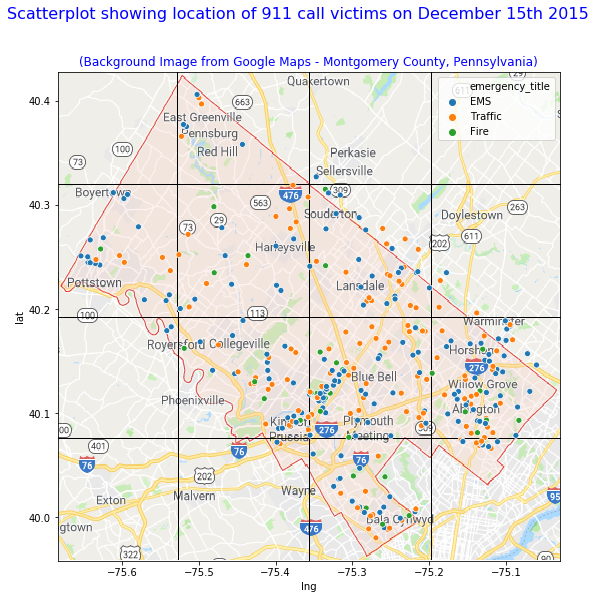

In [17]:
query = data[data['timeStamp'].str.contains('12/15/2015')]
query['emergency_title'] = query.apply(lambda row: row['title'].split(':')[0], axis=1)

fig = plt.figure(figsize=(9,9))

plt.subplot(111)
map_img = mpimg.imread('mont.png') 

scat = sns.scatterplot(x = 'lng',
                y = 'lat',
                hue = 'emergency_title',
                data = query, 
                zorder=2)
scat.imshow(map_img,
          aspect = scat.get_aspect(),
          extent = scat.get_xlim() + scat.get_ylim(),
          zorder = 1) 

plt.suptitle('Scatterplot showing location of 911 call victims on December 15th 2015 ', fontsize=16, color='blue')
plt.title('(Background Image from Google Maps - Montgomery County, Pennsylvania)', fontsize=12, color='blue')
plt.show()

#### Check for Missing Values

Let us check if any column has missing values.

In [18]:
print ('Missing Values in column - lat       : {}'.format(data['lat'].isnull().sum()))
print ('Missing Values in column - lng       : {}'.format(data['lng'].isnull().sum()))
print ('Missing Values in column - desc      : {}'.format(data['desc'].isnull().sum()))
print ('Missing Values in column - zip       : {}'.format(data['zip'].isnull().sum()))
print ('Missing Values in column - title     : {}'.format(data['title'].isnull().sum()))
print ('Missing Values in column - timeStamp : {}'.format(data['timeStamp'].isnull().sum()))
print ('Missing Values in column - twp       : {}'.format(data['twp'].isnull().sum()))
print ('Missing Values in column - addr      : {}'.format(data['addr'].isnull().sum()))
print ('Missing Values in column - e         : {}'.format(data['e'].isnull().sum()))

Missing Values in column - lat       : 0
Missing Values in column - lng       : 0
Missing Values in column - desc      : 0
Missing Values in column - zip       : 37009
Missing Values in column - title     : 0
Missing Values in column - timeStamp : 0
Missing Values in column - twp       : 109
Missing Values in column - addr      : 0
Missing Values in column - e         : 0


#### Remove unwanted columns

In [19]:
# Deleting unwanted columns
data = data.drop(['twp', 'desc', 'zip', 'addr', 'e'], axis = 1)
data = data.drop(['lat', 'lng', 'lat_grid_no', 'lng_grid_no'], axis=1)
data.head(1)

,title,timeStamp,region
0,EMS: BACK PAINS/INJURY,12/10/2015 17:10,R8


#### "timeStamp" column split into date and time:

Timestamp is split into date and time. Date and time will be further split after few steps.

In [20]:
# Split timestamp into 2 columns date and time; 
# Then, remove timestamp column. Retain only date and time columns
timestamp = pd.to_datetime(data['timeStamp'])
data = data.drop('timeStamp', axis = 1)
data['date'] = timestamp.dt.date
data['time'] = timestamp.dt.time 
data.head()

,title,region,date,time
0,EMS: BACK PAINS/INJURY,R8,2015-12-10,17:10:00
1,EMS: DIABETIC EMERGENCY,R5,2015-12-10,17:29:00
2,Fire: GAS-ODOR/LEAK,R5,2015-12-10,14:39:00
3,EMS: CARDIAC EMERGENCY,R1,2015-12-10,16:47:00
4,EMS: DIZZINESS,R4,2015-12-10,16:56:00


#### "title" column encoding
"title" column indicates the emergency category. Let us see the unique values in "title" column.

In [21]:
# unique values in title column
print (data.title.unique())

['EMS: BACK PAINS/INJURY' 'EMS: DIABETIC EMERGENCY' 'Fire: GAS-ODOR/LEAK'
 'EMS: CARDIAC EMERGENCY' 'EMS: DIZZINESS' 'EMS: HEAD INJURY'
 'EMS: NAUSEA/VOMITING' 'EMS: RESPIRATORY EMERGENCY'
 'EMS: SYNCOPAL EPISODE' 'Traffic: VEHICLE ACCIDENT -'
 'EMS: VEHICLE ACCIDENT' 'Traffic: DISABLED VEHICLE -'
 'Fire: APPLIANCE FIRE' 'EMS: GENERAL WEAKNESS'
 'EMS: UNKNOWN MEDICAL EMERGENCY' 'EMS: UNRESPONSIVE SUBJECT'
 'Fire: VEHICLE ACCIDENT' 'EMS: ALTERED MENTAL STATUS' 'Fire: FIRE ALARM'
 'EMS: CVA/STROKE' 'Traffic: ROAD OBSTRUCTION -' 'EMS: SUBJECT IN PAIN'
 'EMS: HEMORRHAGING' 'EMS: FALL VICTIM' 'EMS: ASSAULT VICTIM'
 'EMS: SEIZURES' 'Fire: CARBON MONOXIDE DETECTOR' 'EMS: ABDOMINAL PAINS'
 'Fire: PUMP DETAIL' 'Fire: FIRE INVESTIGATION' 'EMS: OVERDOSE'
 'EMS: MATERNITY' 'EMS: UNCONSCIOUS SUBJECT' 'EMS: CHOKING'
 'EMS: LACERATIONS' 'EMS: MEDICAL ALERT ALARM' 'Fire: TRASH/DUMPSTER FIRE'
 'Fire: UNKNOWN TYPE FIRE' 'Fire: BUILDING FIRE'
 'Fire: ELECTRICAL FIRE OUTSIDE' 'Fire: DEBRIS/FLUIDS ON HIGHW

Although there are a lot of categories, each one starts with either "EMS" or "Fire" or "Traffic". So we can broadly classify them as EMS / Fire / Traffic in the next step.

In [22]:
# title_category will have values EMS / Fire / Traffic as below:
data['title_category'] = data.apply(lambda row: row['title'].split(':')[0], axis=1)
data = data.drop('title', axis = 1)
data.head(2)

,region,date,time,title_category
0,R8,2015-12-10,17:10:00,EMS
1,R5,2015-12-10,17:29:00,EMS


#### Plot showing the proportion of different emergencies in the dataset

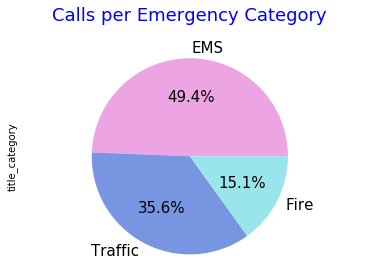

In [23]:
# plot the proportion of different emergencies in the dataset
data['title_category'].value_counts().plot(kind='pie', 
                                           fontsize=15,
                                           autopct='%1.1f%%', 
                                           colors=['#EDA4E3', '#7895E1', '#98E5EC'])
plt.title('Calls per Emergency Category\n', fontsize=18, color='blue')
plt.axis('equal')
plt.show()

#### Plot showing the date vs number of emergencies

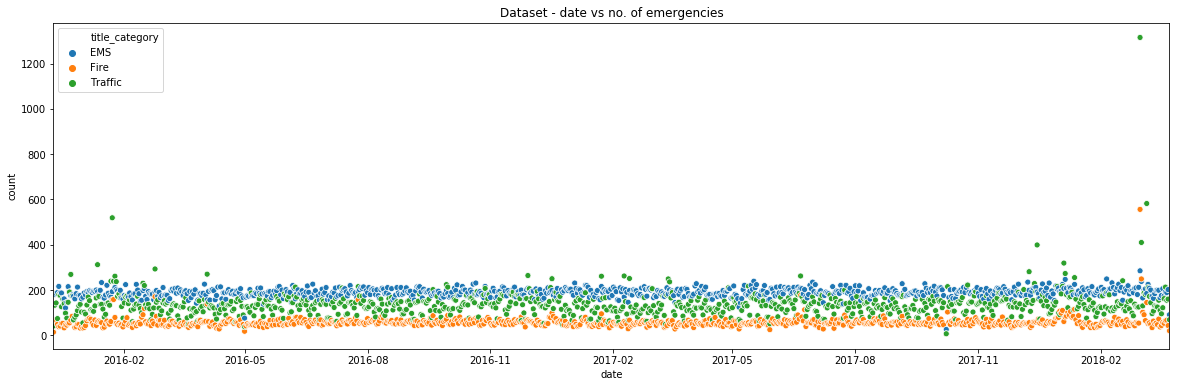

In [24]:
dt = data.groupby(['date', 'title_category']).size().reset_index(name='count')

fig = plt.figure(figsize=(20,6))
sns.scatterplot(x='date', y='count', hue='title_category', data=dt)
plt.xlim(dt['date'].min(), dt['date'].max())
plt.title('Dataset - date vs no. of emergencies')
plt.show()

#### Date and time split

Date and time is split into year, month, day, day of week, time window

In [25]:
# Add new columns "year", "month", "day", "week", "day_of_week"
# "day_of_week":  0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday
# Then, remove column "date"
data['year'] = data.apply(lambda row: row['date'].year, axis=1)
data['month'] = data.apply(lambda row: row['date'].month, axis=1)
data['day'] = data.apply(lambda row: row['date'].day, axis=1)
data['week'] = data.apply(lambda row: row['date'].isocalendar()[1], axis=1)
data['day_of_week'] = data.apply(lambda row: calendar.weekday(row['year'], row['month'], row['day']), axis=1)
data = data.drop('date', axis = 1)
     
# Add a new column "time_window"; Remove existing "time" column. 
# Because "time_window" would generalize well
# 0 => 12AM to 8AM;   1 => 8AM to 4PM;   2 => 4PM to 12AM
now = datetime.now().time()
time_12am = now.replace(hour=0, minute=0, second=0, microsecond=0)
time_8am = now.replace(hour=8, minute=0, second=0, microsecond=0)
time_4pm = now.replace(hour=16, minute=0, second=0, microsecond=0)
def find_time_window(t):
        if (t >= time_12am and t < time_8am):
            return (0) # 12am-8am
        elif (t >= time_8am and t < time_4pm):  
            return (1) # 8am-4pm
        else:
            return (2) # 4pm-12am
data['time_window'] = data.apply(lambda row: find_time_window(row['time']), axis=1)  #find_time_window(row['time'])
data = data.drop('time', axis=1)
data.head(2)

,region,title_category,year,month,day,week,day_of_week,time_window
0,R8,EMS,2015,12,10,50,3,2
1,R5,EMS,2015,12,10,50,3,2


#### Plot showing calls on a sample day - regionwise, timewindow wise for each category

Let us take an example of a day. Say, "12-15-2015". We will see how many calls are recieved on this day. We will analyze this region-wise, emergency-category-wise and time-window-wise. 



*************************PLOTS SHOWING EMERGENCY CALLS RECEIVED ON 15TH DECEMBER 2015*************************


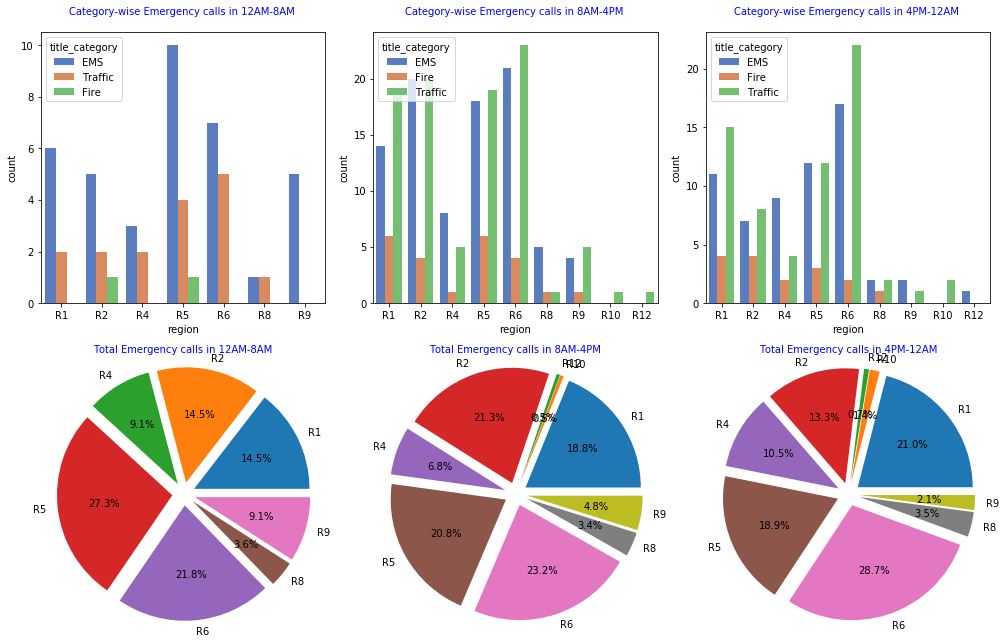

In [26]:
query = data[(data['year']==2015) & (data['month']==12) & (data['day']==15)]
query_data = query.groupby(['region', 'title_category', 'time_window']).size().reset_index(name='count')
query_data_t0 = query_data[query_data['time_window']==0]
query_data_t1 = query_data[query_data['time_window']==1]
query_data_t2 = query_data[query_data['time_window']==2]

q_data = query.groupby(['region', 'time_window']).size().reset_index(name='count')
q_data_t0 = q_data[q_data['time_window']==0]
q_data_t1 = q_data[q_data['time_window']==1]
q_data_t2 = q_data[q_data['time_window']==2]

def find_region_order(df):
    order = list(df['region'].unique())
    for i,item in enumerate(order):
        order[i] = int(item.split('R')[1])
    order.sort()
    for i,item in enumerate(order):
        order[i] = 'R'+str(item)
    return order

print ('\n\n*************************PLOTS SHOWING EMERGENCY CALLS RECEIVED ON 15TH DECEMBER 2015*************************')
fig = plt.figure(figsize=(14,9))
#palette1 = ['#EB6D6D', '#FCF003', '#A3FC71', '#F399F7', '#D3546F', '#D3546F', '#05FE9C', '#4298F3', '#C79BE1']

plt.subplot(231)
sns.barplot(x='region',
            y='count',
            data=query_data_t0, 
            order= find_region_order(query_data_t0),
            hue='title_category', 
            palette='muted')
plt.title('Category-wise Emergency calls in 12AM-8AM \n', fontsize=10, color='blue')

plt.subplot(232)
sns.barplot(x='region',
            y='count',
            data=query_data_t1, 
            order= find_region_order(query_data_t1),
            hue='title_category', 
            palette='muted')
plt.title('Category-wise Emergency calls in 8AM-4PM \n', fontsize=10, color='blue')

plt.subplot(233)
sns.barplot(x='region',
            y='count',
            data=query_data_t2, 
            order= find_region_order(query_data_t2),
            hue='title_category', 
            palette='muted')
plt.title('Category-wise Emergency calls in 4PM-12AM \n', fontsize=10, color='blue')

plt.subplot(234)
explode = list(np.ones_like(q_data_t0['region']) * [0.1])
plt.pie(q_data_t0['count'],
        labels = q_data_t0['region'],
        explode=explode,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Total Emergency calls in 12AM-8AM', fontsize=10, color='blue')

plt.subplot(235)
explode = list(np.ones_like(q_data_t1['region']) * [0.1])
plt.pie(q_data_t1['count'],
        labels = q_data_t1['region'],
        explode=explode,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Total Emergency calls in 8AM-4PM', fontsize=10, color='blue')

plt.subplot(236)
explode = list(np.ones_like(q_data_t2['region']) * [0.1])
plt.pie(q_data_t2['count'],
        labels = q_data_t2['region'],
        explode=explode,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Total Emergency calls in 4PM-12AM', fontsize=10, color='blue')

plt.tight_layout()

plt.show()

#### Monthwise Analysis of Calls

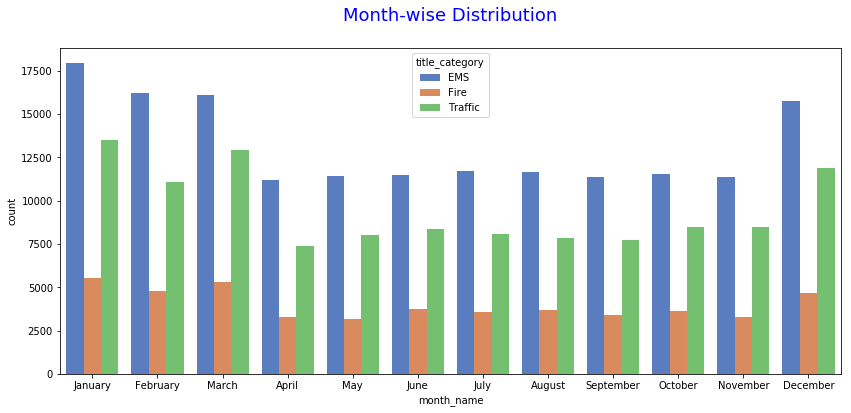

In [27]:
data['month_name'] = data.apply(lambda row: calendar.month_name[row['month']], axis=1)
order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(14,6))
sns.countplot(x='month_name',
              data=data, 
              order= order,
              hue='title_category', 
              palette='muted')
plt.title('Month-wise Distribution\n', fontsize=18, color='blue')
plt.show()
data = data.drop('month_name', axis=1)

#### Day wise Analysis of Calls

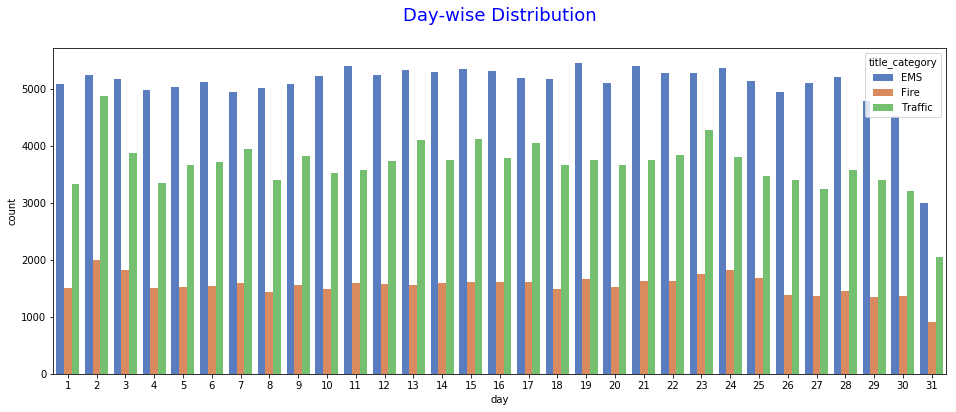

In [28]:
plt.figure(figsize=(16,6))
sns.countplot(x='day',
              data=data, 
              order= list(np.arange(32))[1:],
              hue='title_category', 
              palette='muted')
plt.title('Day-wise Distribution\n', fontsize=18, color='blue')
plt.show()

#### Weekday wise analysis of Calls

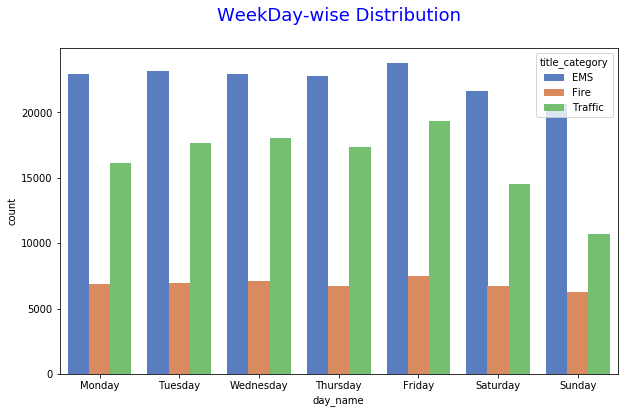

In [29]:
data['day_name'] = data.apply(lambda row: calendar.day_name[row['day_of_week']], axis=1)
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10,6))
sns.countplot(x='day_name', 
              data=data, 
              order=order, 
              hue='title_category', 
              palette='muted')
plt.title('WeekDay-wise Distribution\n', fontsize=18, color='blue')
plt.show()
data = data.drop('day_name', axis=1)

#### Time window wise Analysis of Calls

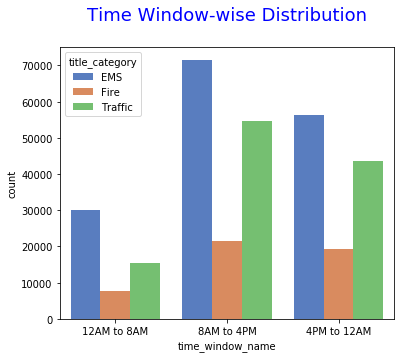

In [30]:
t_window = ['12AM to 8AM', '8AM to 4PM', '4PM to 12AM']
data['time_window_name'] = data.apply(lambda row: t_window[row['time_window']], axis=1)
plt.figure(figsize=(6,5))
sns.countplot(x='time_window_name', 
              data=data, 
              order=t_window, 
              hue='title_category', 
              palette='muted')
plt.title('Time Window-wise Distribution\n', fontsize=18, color='blue')
plt.show()
data = data.drop('time_window_name', axis=1)

#### Region wise Analysis of Calls

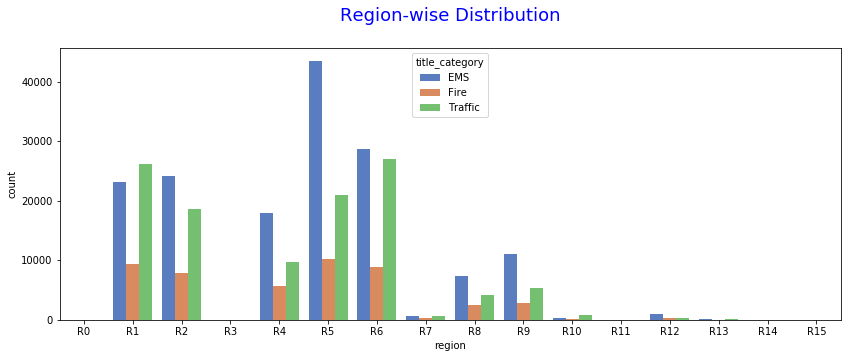

In [31]:
order = ['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15']
plt.figure(figsize=(14,5))
sns.countplot(x='region', 
              data=data, 
              order=order, 
              hue='title_category', 
              palette='muted')
plt.title('Region-wise Distribution\n', fontsize=18, color='blue')
plt.show()

#### Scaling Numerical Features

As it is a good practice to perform scaling on numerical features, we can do that in the next step. This will ensure that the model treats each feature equally.

In [32]:
numeric_features = ['year', 'month', 'day', 'week', 'day_of_week', 'time_window']
scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])
data.head(2)

,region,title_category,year,month,day,week,day_of_week,time_window
0,R8,EMS,0.0,1.0,0.3,0.942308,0.5,1.0
1,R5,EMS,0.0,1.0,0.3,0.942308,0.5,1.0


Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning.

#### One-hot-encoding:

One Hot Encoding is done to non-numeric features. Here, it is for the columns "region" and "title_category".

In [33]:
data = pd.get_dummies(data)
data.head()

,year,month,day,week,day_of_week,time_window,region_R1,region_R10,region_R12,region_R13,...,region_R3,region_R4,region_R5,region_R6,region_R7,region_R8,region_R9,title_category_EMS,title_category_Fire,title_category_Traffic
0,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0.0,1.0,0.3,0.942308,0.5,0.5,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.0,1.0,0.3,0.942308,0.5,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


#### Rearrange the dataset by "groupby" to get the emergencies count

In [34]:
data = data.groupby(['year', 'month', 'day', 'week', 'day_of_week', 'time_window',
                    'region_R8', 'region_R5', 'region_R1', 'region_R4', 'region_R6', 'region_R9', 'region_R2', 'region_R12', 
                     'region_R10', 'region_R7', 'region_R13', 'region_R3'])[['title_category_EMS', 
                                                                'title_category_Fire', 
                                                                'title_category_Traffic']].sum().astype(int).reset_index()
print ('Number of rows in grouped dataset : {}'.format(len(data)))

data.head()

Number of rows in grouped dataset : 20334


,year,month,day,week,day_of_week,time_window,region_R8,region_R5,region_R1,region_R4,...,region_R9,region_R2,region_R12,region_R10,region_R7,region_R13,region_R3,title_category_EMS,title_category_Fire,title_category_Traffic
0,0.0,1.0,0.3,0.942308,0.5,0.5,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,0,1,0,0,0,0,0,5,3,8
3,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,0
4,0.0,1.0,0.3,0.942308,0.5,1.0,0,0,0,0,...,0,0,0,0,0,0,0,8,1,9


#### Split data into features and labels

In [35]:
labels = data[['title_category_EMS', 'title_category_Fire', 'title_category_Traffic']]
features = data.drop(['title_category_EMS', 'title_category_Fire', 'title_category_Traffic'], axis = 1)

#### Split into training set and testing set

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=False)

#### Benchmark - Linear Regression

In [37]:
reg_lr = LinearRegression()
reg_lr.fit(X_train, y_train['title_category_EMS'])
y_pred = reg_lr.predict(X_test)
score = r2_score(y_test['title_category_EMS'], y_pred)
print ('Linear regression EMS score : {}'.format(score))

Linear regression EMS score : 0.6459678339352632


In [38]:
reg_lr = LinearRegression()
reg_lr.fit(X_train, y_train['title_category_Fire'])
y_pred = reg_lr.predict(X_test)
score = r2_score(y_test['title_category_Fire'], y_pred)
print ('Linear regression Fire score : {}'.format(score))

Linear regression Fire score : 0.2242849111228471


In [39]:
reg_lr = LinearRegression()
reg_lr.fit(X_train, y_train['title_category_Traffic'])
y_pred = reg_lr.predict(X_test)
score = r2_score(y_test['title_category_Traffic'], y_pred)
print ('Linear regression Traffic score : {}'.format(score))

Linear regression Traffic score : 0.26920499523968944


#### Xgboost Model

In [40]:
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X_train, y_train['title_category_EMS'])
y_pred_ems = reg_xgb.predict(X_test)
score = r2_score(y_test['title_category_EMS'], y_pred_ems)
print ('xgboosting EMS score : {}'.format(score))
#print (t2-t1)

xgboosting EMS score : 0.7933299093559492


In [41]:
#reg_xgb = xgb.XGBRegressor(n_estimators=80, learning_rate=0.1, max_depth=3)
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X_train, y_train['title_category_Fire'])
y_pred_fire = reg_xgb.predict(X_test)
score = r2_score(y_test['title_category_Fire'], y_pred_fire)
print ('xgboosting Fire score : {}'.format(score))
#print (t2-t1)

xgboosting Fire score : 0.2711290414050589


In [42]:
#reg_xgb = xgb.XGBRegressor(n_estimators=90, learning_rate=0.1, max_depth=4)
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X_train, y_train['title_category_Traffic'])
y_pred_traffic = reg_xgb.predict(X_test)
score = r2_score(y_test['title_category_Traffic'], y_pred_traffic)
print ('xgboosting Traffic score : {}'.format(score))
#print (t2-t1)

xgboosting Traffic score : 0.38537051363917596


#### Tune Xgboost Model

Tune the parameters n_estimators, max_depth, learning_rate and early_stopping_rounds

In [43]:
# For tuning there is a need for validation set. So a part of the training set is set aside for validation.
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [44]:
xgbst_ems = xgb.XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.01)
xgbst_ems.fit(X_tr, 
          y_tr['title_category_EMS'], 
          early_stopping_rounds=100, 
          eval_set=[(X_val, y_val['title_category_EMS'])],
          verbose=False)
y_pred_ems_t = xgbst_ems.predict(X_test)
score = r2_score(y_test['title_category_EMS'], y_pred_ems_t)
print ('TUNED MODEL : xgboosting EMS score : {}'.format(score))

TUNED MODEL : xgboosting EMS score : 0.8017595895675822


In [45]:
xgbst_fire = xgb.XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.01)
xgbst_fire.fit(X_tr, 
          y_tr['title_category_Fire'], 
          early_stopping_rounds=100, 
          eval_set=[(X_val, y_val['title_category_Fire'])],
          verbose=False)
y_pred_fire_t = xgbst_fire.predict(X_test)
score = r2_score(y_test['title_category_Fire'], y_pred_fire_t)
print ('TUNED MODEL : xgboosting Fire score : {}'.format(score))

TUNED MODEL : xgboosting Fire score : 0.2704405260319347


In [46]:
xgbst_traffic = xgb.XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.02)
xgbst_traffic.fit(X_tr, 
          y_tr['title_category_Traffic'], 
          early_stopping_rounds=100, 
          eval_set=[(X_val, y_val['title_category_Traffic'])],
          verbose=False)
y_pred_traffic_t = xgbst_traffic.predict(X_test)
score = r2_score(y_test['title_category_Traffic'], y_pred_traffic_t)
print ('TUNED MODEL : xgboosting Traffic score : {}'.format(score))

TUNED MODEL : xgboosting Traffic score : 0.38928045934118194


#### Visualize output of first 5 rows testing set - Predicted & Actual

**********************Sample of Predicted and Actual Output**********************


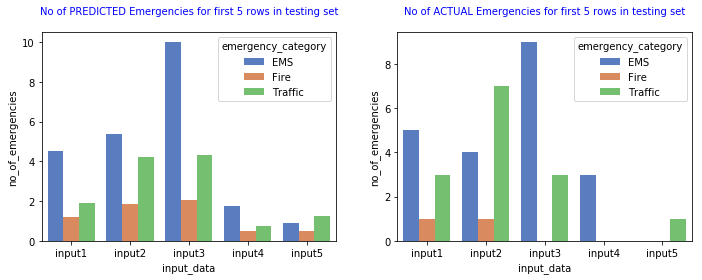

In [52]:
visual_ems = pd.DataFrame(columns=['input_data', 'emergency_category', 'no_of_emergencies'])
visual_fire = pd.DataFrame(columns=['input_data', 'emergency_category', 'no_of_emergencies'])
visual_traffic = pd.DataFrame(columns=['input_data', 'emergency_category', 'no_of_emergencies'])

visual_ems['input_data'] = ['input1', 'input2', 'input3', 'input4', 'input5']
visual_ems['emergency_category'] = ['EMS', 'EMS', 'EMS', 'EMS', 'EMS']
visual_ems['no_of_emergencies'] = y_pred_ems_t[0:5]

visual_fire['input_data'] = ['input1', 'input2', 'input3', 'input4', 'input5']
visual_fire['emergency_category'] = ['Fire', 'Fire', 'Fire', 'Fire', 'Fire']
visual_fire['no_of_emergencies'] = y_pred_fire[0:5]

visual_traffic['input_data'] = ['input1', 'input2', 'input3', 'input4', 'input5']
visual_traffic['emergency_category'] = ['Traffic', 'Traffic', 'Traffic', 'Traffic', 'Traffic']
visual_traffic['no_of_emergencies'] = y_pred_traffic_t[0:5]

visual = visual_ems.append(visual_fire)
visual = visual.append(visual_traffic)

visual_ems_actual = pd.DataFrame(columns=['input_data', 'emergency_category', 'no_of_emergencies'])
visual_fire_actual = pd.DataFrame(columns=['input_data', 'emergency_category', 'no_of_emergencies'])
visual_traffic_actual = pd.DataFrame(columns=['input_data', 'emergency_category', 'no_of_emergencies'])

visual_ems_actual['input_data'] = ['input1', 'input2', 'input3', 'input4', 'input5']
visual_ems_actual['emergency_category'] = ['EMS', 'EMS', 'EMS', 'EMS', 'EMS']
visual_ems_actual['no_of_emergencies'] = list(y_test['title_category_EMS'].head())

visual_fire_actual['input_data'] = ['input1', 'input2', 'input3', 'input4', 'input5']
visual_fire_actual['emergency_category'] = ['Fire', 'Fire', 'Fire', 'Fire', 'Fire']
visual_fire_actual['no_of_emergencies'] = list(y_test['title_category_Fire'].head())

visual_traffic_actual['input_data'] = ['input1', 'input2', 'input3', 'input4', 'input5']
visual_traffic_actual['emergency_category'] = ['Traffic', 'Traffic', 'Traffic', 'Traffic', 'Traffic']
visual_traffic_actual['no_of_emergencies'] = list(y_test['title_category_Traffic'].head())

visual_actual = visual_ems_actual.append(visual_fire_actual)
visual_actual = visual_actual.append(visual_traffic_actual)


print ('**********************Sample of Predicted and Actual Output**********************')
fig = plt.figure(figsize=(10,4))

plt.subplot(121)
sns.barplot(x='input_data',
            y='no_of_emergencies',
            hue='emergency_category',
            data=visual, 
            order= ['input1', 'input2', 'input3', 'input4', 'input5'],
            palette='muted')
plt.title('No of PREDICTED Emergencies for first 5 rows in testing set\n', fontsize=10, color='blue')

plt.subplot(122)
sns.barplot(x='input_data',
            y='no_of_emergencies',
            hue='emergency_category',
            data=visual_actual, 
            order= ['input1', 'input2', 'input3', 'input4', 'input5'],
            palette='muted')
plt.title('No of ACTUAL Emergencies for first 5 rows in testing set\n', fontsize=10, color='blue')

plt.tight_layout()
plt.show()